# Racing Analysis

In [131]:
from capo.load_datasets import get_tasks
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
prefix = r"../results/racing_test/racing_experiment_CAPO_mistral/"

steprs_path = glob(prefix + r"*/step_results.csv")[0]
ps_path = glob(prefix + r"*/prompt_scores.csv")[0]
args_path = glob(prefix + r"*/args.json")[0]

df = pd.read_csv(steprs_path)
df_ps = pd.read_csv(ps_path)
df_ps.rename(columns={"Unnamed: 0": "prompt"}, inplace=True)

try:
    steprseval_path = glob(prefix + r"*/step_results_eval.csv")[0]
    df_eval = pd.read_csv(steprseval_path)
except:
    df_eval = None
    print("No step results eval file found")

args = pd.read_json(args_path, typ="series")

No step results eval file found


In [133]:
task, _, _ = get_tasks(
    dataset_name=args.dataset,
    optimizer_name=args.optimizer,
    seed=args.random_seed,
    block_size=30,
)

init_prompts = task.initial_prompts;

C:\Users\schla\git\capo\capo\load_datasets.py:72: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\schla\git\capo\capo\load_datasets.py:77: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\schla\git\capo\capo\load_datasets.py:72: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

## Initial Prompts Analysis

In [134]:
df["contains_init"] = df["prompt"].apply(lambda x: any([prompt in x for prompt in init_prompts]))

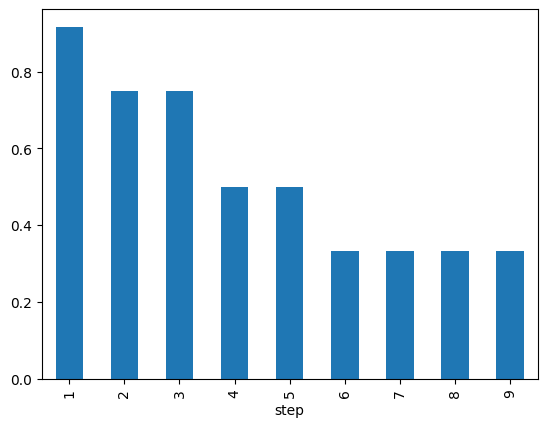

In [135]:
df.groupby("step").mean(numeric_only=True)["contains_init"].plot(kind="bar");

In [136]:
if df_eval is not None:
    df_eval["contains_init"] = df_eval["prompt"].apply(
        lambda x: any([prompt in x for prompt in init_prompts])
    )
    df_eval.groupby("prompt").first().boxplot(column="test_score", by="contains_init")
    df_eval[df_eval["contains_init"]].groupby("prompt", as_index=False).mean(numeric_only=True)[
        ["prompt", "test_score"]
    ].sort_values("test_score", ascending=False)

## Prompt Survival Analysis

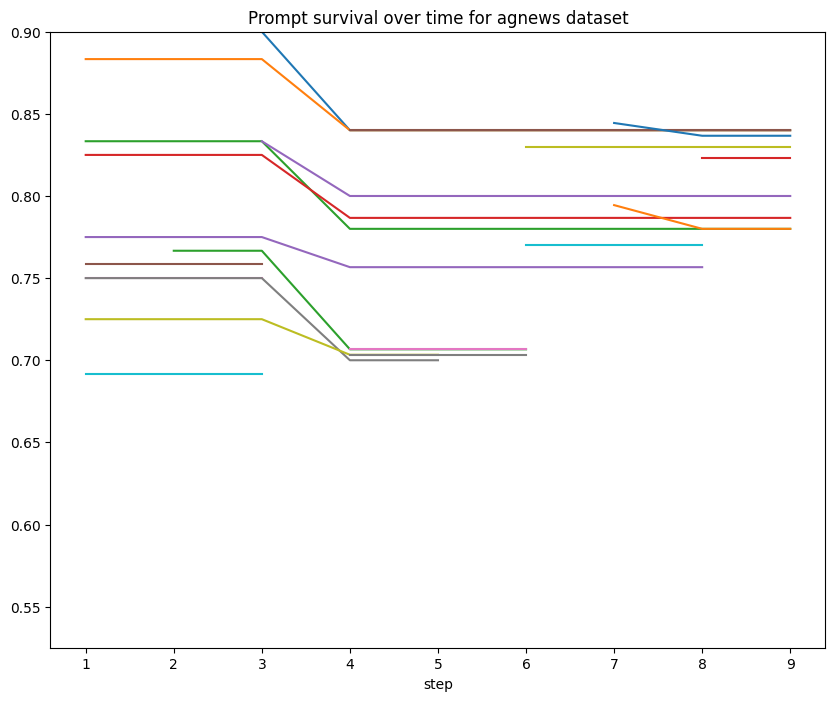

In [137]:
fig, ax = plt.subplots(figsize=(10, 8))
for prompt in df["prompt"].unique():
    df[df["prompt"] == prompt].plot(x="step", y="score", ax=ax)  # <-- changed to test_score
ax.get_legend().remove()
ax.set_ylim(min(df["score"]), max(df["score"]))  # <-- changed to test_score
ax.set_title(f"Prompt survival over time for {args.dataset} dataset")
plt.show()

## Block Score Analysis

In [138]:
df["prompt_short"] = df["prompt"].apply(lambda x: " ".join(x.split()[:20]))

In [146]:
df_ps["evaluated_blocks"] = 10 - df_ps.isnull().sum(axis=1)

In [147]:
df_with_blocks = df.merge(df_ps, on=["prompt", "step"], how="left")
df_with_blocks

,step,timestamp,time_elapsed,score,prompt,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,contains_init,...,1,2,3,4,5,6,7,8,9,evaluated_blocks
0,1,2025-03-21 00:37:07.168305,271.950553,0.900000,"Given this news article, what category does it...",1401,491,698057,48025,True,...,0.933333,0.866667,0.900000,NaN,NaN,NaN,NaN,NaN,NaN,4.0
1,1,2025-03-21 00:37:07.168305,271.950553,0.883333,"Based on the content of this news article, cla...",1401,491,698057,48025,True,...,0.933333,0.833333,0.900000,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,1,2025-03-21 00:37:07.168305,271.950553,0.833333,I need you to classify this news content into ...,1401,491,698057,48025,True,...,0.866667,0.700000,0.900000,NaN,NaN,NaN,NaN,NaN,NaN,4.0
3,1,2025-03-21 00:37:07.168305,271.950553,0.825000,Your task is to categorize the following news ...,1401,491,698057,48025,True,...,0.933333,0.800000,0.766667,NaN,NaN,NaN,NaN,NaN,NaN,4.0
4,1,2025-03-21 00:37:07.168305,271.950553,0.775000,"As an AI assistant, your task is to categorize...",1401,491,698057,48025,False,...,0.900000,0.766667,0.733333,NaN,NaN,NaN,NaN,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,9,2025-03-21 00:50:43.453791,31.325404,0.823333,"For the given news article, determine which ca...",1901,972,83398,4858,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,9,2025-03-21 00:50:43.453791,31.325404,0.800000,"As an AI assistant, you are tasked with sortin...",1901,972,83398,4858,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,9,2025-03-21 00:50:43.453791,31.325404,0.786667,Your task is to categorize the following news ...,1901,972,83398,4858,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,9,2025-03-21 00:50:43.453791,31.325404,0.780000,I need you to classify this news content into ...,1901,972,83398,4858,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
# do the same with plotly
fig = px.line(
    df_with_blocks,
    x="step",
    y="score",  # <--
    color="prompt",
    custom_data=[df_with_blocks["prompt_short"], df_with_blocks["evaluated_blocks"]],
)
fig.update_xaxes(title="step")
fig.update_layout(title=f"Prompt survival over time for {args.dataset} dataset")

# # do not show the legend
fig.update_layout(showlegend=False, height=800)

# # show prompt_short instead of prompt in the hover
fig.update_traces(
    hovertemplate="prompt: %{customdata[0]}<br>score: %{y}<br>test score:%{customdata[2]}<br>evaluated blocks:%{customdata[1]}",
    name="",
)
fig.show()